<a href="https://colab.research.google.com/github/osgeokr/kari-sdm/blob/main/003_environmental_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap
import geemap.colormaps as cm

# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize(project='ee-foss4g')

In [36]:
import geemap
import os, requests
import pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt
import rasterio

from google.colab import files
from google.colab import drive

from rasterio.mask import mask
from rasterio.plot import show

In [21]:
# 대한민국 범위 좌표 지정(좌하단 : 우상단 좌표)
rectangle_coords = [
    [125.0765578311700068, 33.1124998462386984],
    [131.8727812628719960, 38.4000004985049017],
]

# 직사각형 생성
rectangle = ee.Geometry.Rectangle(rectangle_coords)

# 직사각형을 Feature로 변환
feature = ee.Feature(rectangle)

# FeatureCollection 생성
kr = ee.FeatureCollection([feature])

m = geemap.Map(layout={'height':'400px', 'width':'800px'})
m.addLayer(kr, {}, "Republic of Korea")
m.centerObject(kr, 6)
m

Map(center=[35.77459004930315, 128.47466954702105], controls=(WidgetControl(options=['position', 'transparent_…

In [22]:
# NASA SRTM Digital Elevation 30m
elevation = ee.Image("USGS/SRTMGL1_003").select('elevation').clip(kr.geometry())

# Elevation layer
Map = geemap.Map(layout={'height':'400px', 'width':'800px'})

vis_params = {'bands':['elevation'], 'min': 0, 'max': 1800, 'palette': cm.palettes.terrain}
Map.addLayer(elevation, vis_params, 'elevation')
Map.add_colorbar(vis_params, label="Elevation (m)", orientation="vertical", layer_name="elevation")
Map.centerObject(kr.geometry(), 6)
Map

Map(center=[35.77459004930315, 128.47466954702105], controls=(WidgetControl(options=['position', 'transparent_…

In [23]:
%%time

import time

# 이미지를 Google Drive에 내보내기
task = ee.batch.Export.image.toDrive(
    image=elevation,
    description='DEM',
    folder='kari-sdm',
    scale=30,  # 이미지의 해상도
    region=kr.geometry(),  # 내보낼 영역
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

# 내보내기 작업 시작
task.start()

# 내보내기 작업 상태 확인
print('Export task started. Checking status...')

while True:
    status = task.status()
    state = status['state']
    print('Polling for task (id: {}). Status: {}'.format(task.id, state))
    if state in ['COMPLETED', 'FAILED']:
        break
    time.sleep(60)  # 60초 간격으로 상태 확인

# 완료 후 상태 출력
print('Task completed. Final status:')
print(status)

Export task started. Checking status...
Polling for task (id: 7GGI743FQ3HGXNDBC3SFQPT4). Status: READY
Polling for task (id: 7GGI743FQ3HGXNDBC3SFQPT4). Status: RUNNING
Polling for task (id: 7GGI743FQ3HGXNDBC3SFQPT4). Status: RUNNING
Polling for task (id: 7GGI743FQ3HGXNDBC3SFQPT4). Status: RUNNING
Polling for task (id: 7GGI743FQ3HGXNDBC3SFQPT4). Status: RUNNING
Polling for task (id: 7GGI743FQ3HGXNDBC3SFQPT4). Status: RUNNING
Polling for task (id: 7GGI743FQ3HGXNDBC3SFQPT4). Status: RUNNING
Polling for task (id: 7GGI743FQ3HGXNDBC3SFQPT4). Status: RUNNING
Polling for task (id: 7GGI743FQ3HGXNDBC3SFQPT4). Status: RUNNING
Polling for task (id: 7GGI743FQ3HGXNDBC3SFQPT4). Status: RUNNING
Polling for task (id: 7GGI743FQ3HGXNDBC3SFQPT4). Status: RUNNING
Polling for task (id: 7GGI743FQ3HGXNDBC3SFQPT4). Status: RUNNING
Polling for task (id: 7GGI743FQ3HGXNDBC3SFQPT4). Status: COMPLETED
Task completed. Final status:
{'state': 'COMPLETED', 'description': 'DEM', 'priority': 100, 'creation_timestamp_ms'

In [25]:
# Google Drive를 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!pip install -q -U rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 46.7 MB/s eta 0:00:00


In [34]:
# 경로 설정
folder_path = '/content/drive/My Drive/kari-sdm'  # kari-sdm 폴더의 경로
dem_path = os.path.join(folder_path, 'DEM.tif')
gpkg_path = os.path.join(folder_path, 'KR.gpkg')
output_path = os.path.join(folder_path, 'DEM_KR.tif')

# 폴리곤 파일 읽기
gdf = gpd.read_file(gpkg_path)
geoms = gdf.geometry.values  # 폴리곤의 geometry 가져오기

# DEM 파일 읽기
with rasterio.open(dem_path) as src:
    out_image, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()

# 업데이트할 메타데이터 설정
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# 결과를 GeoTIFF로 저장
with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(out_image)

print(f"Clipped DEM saved to {output_path}")

Clipped DEM saved to /content/drive/My Drive/kari-sdm/DEM_KR.tif


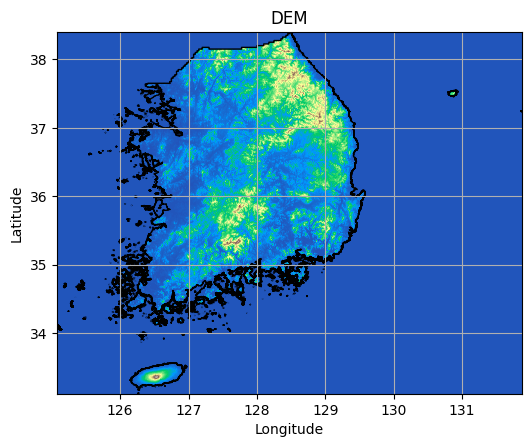

In [41]:
# 경로 설정
folder_path = "/content/drive/My Drive/kari-sdm"  # kari-sdm 폴더의 경로
dem_path = os.path.join(folder_path, "DEM_KR.tif")
kr_path = os.path.join(folder_path, "KR.gpkg")

# 대한민국 경계 읽기
kr = gpd.read_file(kr_path)

# DEM 데이터 읽기
with rasterio.open(dem_path) as src:
    dem_data = src.read(1)  # 첫 번째 밴드 읽기
    dem_extent = src.bounds  # DEM의 범위 가져오기
    dem_transform = src.transform  # 변환 정보 가져오기
    dem_meta = src.meta.copy()  # 메타데이터 복사

# 플롯 설정
fig, ax = plt.subplots(figsize=(6, 6))

# DEM 데이터 플롯
show(
    dem_data,
    transform=dem_transform,
    ax=ax,
    cmap="terrain",
    extent=[dem_extent.left, dem_extent.right, dem_extent.bottom, dem_extent.top],
)

# 대한민국 경계 플롯
kr.plot(ax=ax, color="none", edgecolor="black")

# 범례, 제목, 축 레이블, 그리드 설정
plt.title("DEM")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# 좌표 비율 유지
ax.set_aspect("equal", "box")

# 플롯 표시
plt.show()

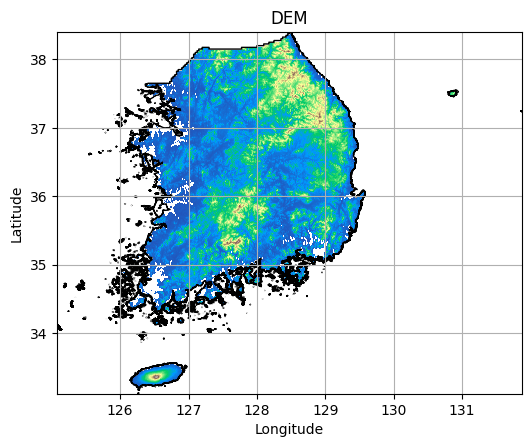

In [46]:
import numpy as np

# 경로 설정
folder_path = "/content/drive/My Drive/kari-sdm"  # kari-sdm 폴더의 경로
dem_path = os.path.join(folder_path, "DEM_KR.tif")
kr_path = os.path.join(folder_path, "KR.gpkg")

# 대한민국 경계 읽기
kr = gpd.read_file(kr_path)

# DEM 데이터 읽기
with rasterio.open(dem_path) as src:
    dem_data = src.read(1)  # 첫 번째 밴드 읽기
    dem_extent = src.bounds  # DEM의 범위 가져오기
    dem_transform = src.transform  # 변환 정보 가져오기
    dem_meta = src.meta.copy()  # 메타데이터 복사

# 픽셀 값이 0인 부분을 마스킹
dem_data_masked = np.ma.masked_equal(dem_data, 0)

# 플롯 설정
fig, ax = plt.subplots(figsize=(6, 6))

# DEM 데이터 플롯 (마스킹 적용)
show(
    dem_data_masked,
    transform=dem_transform,
    ax=ax,
    cmap="terrain",
    extent=[dem_extent.left, dem_extent.right, dem_extent.bottom, dem_extent.top],
)

# 대한민국 경계 플롯
kr.plot(ax=ax, color="none", edgecolor="black")

# 범례, 제목, 축 레이블, 그리드 설정
plt.title("DEM")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

# 좌표 비율 유지
ax.set_aspect("equal", "box")

# 플롯 표시
plt.show()

In [43]:
# FeatureCollection 생성
kr = ee.FeatureCollection([feature])

# Global Forest Cover Change (GFCC) Tree Cover Multi-Year Global 30m
tcc = (
    ee.ImageCollection("NASA/MEASURES/GFCC/TC/v3")
    .filterDate("2000-01-01", "2015-12-31")
    .select("tree_canopy_cover")
    .median()
    .clip(kr.geometry())
)

# TCC layer
Map = geemap.Map(layout={"height": "400px", "width": "800px"})

vis_params = {
    "bands": ["tree_canopy_cover"],
    "min": 0,
    "max": 100,
    "palette": ["ffffff", "afce56", "5f9c00", "0e6a00", "003800"],
}
Map.addLayer(tcc, vis_params, 'tree_canopy_cover')
Map.add_colorbar(
    vis_params, label="Tree Canopy Cover (%)", orientation="vertical", layer_name="TCC"
)
Map.centerObject(kr.geometry(), 6)
Map

Map(center=[35.77459004930315, 128.47466954702105], controls=(WidgetControl(options=['position', 'transparent_…

In [44]:
%%time

import time

# 이미지를 Google Drive에 내보내기
task = ee.batch.Export.image.toDrive(
    image=tcc,
    description='TCC',
    folder='kari-sdm',
    scale=30,  # 이미지의 해상도
    region=kr.geometry(),  # 내보낼 영역
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

# 내보내기 작업 시작
task.start()

# 내보내기 작업 상태 확인
print('Export task started. Checking status...')

while True:
    status = task.status()
    state = status['state']
    print('Polling for task (id: {}). Status: {}'.format(task.id, state))
    if state in ['COMPLETED', 'FAILED']:
        break
    time.sleep(60)  # 60초 간격으로 상태 확인

# 완료 후 상태 출력
print('Task completed. Final status:')
print(status)

Export task started. Checking status...
Polling for task (id: HPYG4DXRXPPGNWRJUDH5EYWI). Status: READY
Polling for task (id: HPYG4DXRXPPGNWRJUDH5EYWI). Status: RUNNING
Polling for task (id: HPYG4DXRXPPGNWRJUDH5EYWI). Status: RUNNING
Polling for task (id: HPYG4DXRXPPGNWRJUDH5EYWI). Status: RUNNING
Polling for task (id: HPYG4DXRXPPGNWRJUDH5EYWI). Status: RUNNING
Polling for task (id: HPYG4DXRXPPGNWRJUDH5EYWI). Status: RUNNING
Polling for task (id: HPYG4DXRXPPGNWRJUDH5EYWI). Status: RUNNING
Polling for task (id: HPYG4DXRXPPGNWRJUDH5EYWI). Status: RUNNING
Polling for task (id: HPYG4DXRXPPGNWRJUDH5EYWI). Status: RUNNING
Polling for task (id: HPYG4DXRXPPGNWRJUDH5EYWI). Status: COMPLETED
Task completed. Final status:
{'state': 'COMPLETED', 'description': 'TCC', 'priority': 100, 'creation_timestamp_ms': 1723538377168, 'update_timestamp_ms': 1723538889709, 'start_timestamp_ms': 1723538380945, 'task_type': 'EXPORT_IMAGE', 'destination_uris': ['https://drive.google.com/#folders/1tgbSyRRPGeqiA4KO-